<a href="https://colab.research.google.com/github/BiancaStadl/ProjektarbeitML/blob/main/CNN_embedded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GloVe embeddings taken from:

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]

hatespeechdata taken from (https://hatespeechdata.com/): Wiegand, M., Siegel, M. and Ruppenhofer, J., 2018. Overview of the GermEval 2018 Shared Task on the Identification of Offensive Language. In: Proceedings of GermEval 2018, 14th Conference on Natural Language Processing (KONVENS 2018). Vienna, Austria: Research Gate. available on: https://github.com/uds-lsv/GermEval-2018-Data (last checked: 09.05.2021)

wiki detox..https://colab.research.google.com/github/tensorflow/fairness-indicators/blob/master/g3doc/tutorials/Fairness_Indicators_TFCO_Wiki_Case_Study.ipynb#scrollTo=y6T5tlXcdW7J 

In [1]:
#import matplotlib.pyplot as plt -> für evtl Visualisierungen
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import losses 
from keras import optimizers 
from keras import metrics 

#!pip install Tokenizer
from keras.preprocessing.text import Tokenizer
#!pip install pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


Maximale Satzlänge

In [2]:

max_length = 60

In [3]:
url = "https://github.com/uds-lsv/GermEval-2018-Data/archive/master.zip"

dataset = tf.keras.utils.get_file("GermEval-2018-Data-master.zip", url, 
                                   extract=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'GermEval-2018-Data-master')


In [4]:
#os.listdir(dataset_dir)

In [5]:
training_file = os.path.join(dataset_dir, 'germeval2018.training.txt')

testing_file = os.path.join(dataset_dir, 'germeval2018.test.txt')


###Aufbereitung
txt-Dateien lesen, und dabei jede Zeile splitten und teilen
Twitter-Handler entfernen?
Labels von Sätzen trennen, Labels in eigenen Array packen.

####Ressourcen
* https://www.w3schools.com/python/gloss_python_if_statement.asp
* https://stackabuse.com/using-regex-for-text-manipulation-in-python/
* https://www.tutorialspoint.com/python/string_splitlines.htm 
* https://note.nkmk.me/en/python-split-rsplit-splitlines-re/ 
* https://www.w3schools.com/python/python_regex.asp 

gäbe bei keras tf.keras.preprocessing.text_dataset_from_directory, aber dafür müssten die Daten auf bestimmte Weise in Verzeichnis organisiert sein, hier nicht der Fall.


Einteilung der Daten: Testdaten
Trainingsdaten -> noch ca 500 für Validierungsdaten

labels -> "other", also nicht-negative Aussagen bekommen "0", negative Aussagen bekommen "1"

 Regex für Emojis  ->

(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])

genommen von https://www.regextester.com/106421 

In [6]:
def remove_clutter(string):
   string = re.sub("@[^\s]+"," ",string)
   string = re.sub("#[^\s]+"," ", string)
   string = re.sub("\u00a9"," ", string)
   string = re.sub("\u00ae"," ", string)
   string = re.sub("[\u2000-\u3300]"," ", string)
   string = re.sub("\ud83c[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83d[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83e[\ud000-\udfff]"," ", string)
   string = re.sub("😜", " ",string)
   string = re.sub("🍫", " ",string)
   string = re.sub("😁", " ",string)
   string = re.sub("🐖", " ",string)
   string = re.sub("😡", " ",string)
   string = re.sub("😇", " ",string)
   string = re.sub("😬", " ",string)
   string = re.sub("😃", " ",string)
   string = re.sub("😂", " ",string)
   string = re.sub("💙", " ",string)  
   string = re.sub("😛", " ",string)
   string = re.sub("🙏", " ",string)
   string = re.sub("👍", " ",string)
   string = re.sub("🖕", " ",string)
   string = re.sub("😉", " ",string)
   string = re.sub("💩", " ",string)
   string = re.sub("🤢", " ",string)
   string = re.sub("👏", " ",string)
   string = re.sub("😨", " ",string)
   string = re.sub("🤣", " ",string)
   string = re.sub("🤡", " ",string)
   string = re.sub("😈", " ",string)
   string = re.sub("💃🏽", " ",string)
   string = re.sub("👹", " ",string)
   string = re.sub("🤘", " ",string)
   string = re.sub("😱", " ",string)
   string = re.sub("🤔", " ",string) 
   string = re.sub("🌈", " ",string) 
   string = re.sub("💕", " ",string) 
   string = re.sub("👩‍❤️‍👩", " ",string) 
   string = re.sub("😍", " ",string) 
   string = re.sub("👆", " ",string) 
   string = re.sub("😖", " ",string) 
   string = re.sub("👇", " ",string) 
   string = re.sub("🔥", " ",string) 
   string = re.sub("😘", " ",string) 
   string = re.sub("🎉", " ",string) 
   string = re.sub("🤬", " ",string) 
   string = re.sub("👊", " ",string)
   string = re.sub("🇩🇪", " ",string)  
   string = re.sub("💔", " ",string)
   string = re.sub("🙈", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🐟", " ",string)
   string = re.sub("🛶", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😓", " ",string)
   string = re.sub("😳", " ",string)
   string = re.sub("🚀", " ",string)
   string = re.sub("👎", " ",string)
   string = re.sub("😎", " ",string)
   string = re.sub("🐸", " ",string)
   string = re.sub("📈", " ",string)
   string = re.sub("🙂", " ",string)
   string = re.sub("😅", " ",string)
   string = re.sub("😆", " ",string)
   string = re.sub("🙎🏿", " ",string)
   string = re.sub("👎🏽", " ",string)
   string = re.sub("🤭", " ",string)
   string = re.sub("😤", " ",string)
   string = re.sub("😚", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😲", " ",string)
   string = re.sub("🤮", " ",string)
   string = re.sub("🙄", " ",string)
   string = re.sub("🤑", " ",string)
   string = re.sub("🎅", " ",string)
   string = re.sub("👋", " ",string)
   string = re.sub("💪", " ",string)
   string = re.sub("😄", " ",string)
   string = re.sub("🧐", " ",string)
   string = re.sub("😠", " ",string)
   string = re.sub("🎈", " ",string)
   string = re.sub("🚂", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("🚇", " ",string)
   string = re.sub("🚊", " ",string)
   string = re.sub("🤷", " ",string)
   string = re.sub("😥", " ",string)
   string = re.sub("🙃", " ",string)
   string = re.sub("🔩", " ",string)
   string = re.sub("🔧", " ",string)
   string = re.sub("🔨", " ",string)
   string = re.sub("🛠", " ",string)
   string = re.sub("💓", " ",string)
   string = re.sub("💡", " ",string)
   string = re.sub("🍸", " ",string)
   string = re.sub("🥃", " ",string)
   string = re.sub("🥂", " ",string)
   string = re.sub("😷", " ",string)
   string = re.sub("🤐", " ",string)
   string = re.sub("🌎", " ",string)
   string = re.sub("👑", " ",string)
   string = re.sub("🤛", " ",string)
   string = re.sub("😀", " ",string)
   string = re.sub("🛤", " ",string)
   string = re.sub("🎄", " ",string)
   string = re.sub("📴", " ",string)
   string = re.sub("🌭", " ",string)
   string = re.sub("🤕", " ",string)
   string = re.sub("😭", " ",string)
   string = re.sub("🍾", " ",string)
   string = re.sub("🍞", " ",string)
   string = re.sub("🤦", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🕯️", " ",string)

   string = re.sub("OTHER|OFFENSE|ABUSE|INSULT"," ",string)
   return string

In [7]:
statementsForTraining = []
sentimentsForTraining = []


fileToRead = open(training_file, 'r')

while True:
  #next line in file
  line = fileToRead.readline()

  if line == "":
   break

  findSentiment = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)


  statementsForTraining.append(line)
   #sentimentsForTraining.append(findSentiment.group(0))

  if findSentiment.group(0) == "OTHER":  
    sentimentsForTraining.append(0)
  else:
    sentimentsForTraining.append(1)

  if not line:
    break

 #print("{}: {}".format(count,line.strip()))
  
 # print(sentiment.group(0))
 
fileToRead.close()

training_sentences = statementsForTraining
training_labels = sentimentsForTraining

#print(training_sentences[9])
#print(training_labels[9])

#print(len(training_sentences))






In [8]:
##do the same with testdata
statementsForTesting = []
sentimentsForTesting = []

fileToRead = open(testing_file, 'r')

while True:
  #next line in file
  line = fileToRead.readline()

  if line == "":
   break

  sent = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)

    

  statementsForTesting.append(line)
  #print(len(line))
  #sentimentsForTesting.append(sent.group(0))

  if sent.group(0) == "OTHER": 
    sentimentsForTesting.append(0)
  else:
    sentimentsForTesting.append(1)

  if not line:
    break


fileToRead.close()


testing_sentences = statementsForTesting
testing_labels = sentimentsForTesting
#print(len(testing_sentences))
#print(testing_sentences)   
#print(testing_labels)

Padding -> im Prinzip die Sätze alle auf die gleiche Länge bringen (in Theorieteil näher drauf eingehen) -> maxlen-Paramter ist für pad_sequences vorhanden, wenn nicht gesetzt -> alles wird auf die Länge des längsten Satzes aufgefüllt -> print(padded(shape)) gibt aus, wie viele Datensätze padded wurden und gibt an, wie viele Tokens der längste Datensatz hat
print(padded[x]) gibt einen Satz aus (bereits tokenisiert)

Padding -> sowohl für Trainigs- als auch für Testdaten

Und: Daten als numpy-Arrays speichern (notwendig für tensorflow).

 -> Tokenizer https://towardsdatascience.com/text-classification-in-keras-part-2-how-to-use-the-keras-tokenizer-word-representations-fd571674df23 

In [9]:
tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(training_sentences)

#creating a word index - nur die Trainigsdaten
word_index = tokenizer.word_index

validation_size = 500


training_sequences = tokenizer.texts_to_sequences(training_sentences)
padded_training = pad_sequences(training_sequences, maxlen=max_length, padding='post')
print(len(padded_training))

validation_sequences = padded_training[0:validation_size]
validation_labels = training_labels[0:validation_size]

padded_training = padded_training[validation_size:]
training_labels = training_labels[validation_size:]

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
padded_testing = pad_sequences(testing_sequences, maxlen=max_length,  padding='post')

#print(validation_sequences[499])
print(padded_training[0])
#print(len(validation_labels))
#print(len(training_labels))


nppadded_training = np.array(padded_training)
nptraining_labels = np.array(training_labels)

nppadded_validation = np.array(validation_sequences)
npvalidation_labels = np.array(validation_labels)

nppadded_testing = np.array(padded_testing)
nptesting_labels = np.array(testing_labels)


print(len(nppadded_training))
print(len(nptraining_labels))
print(len(word_index))

#print(statementsForTraining[2])
#print(nppadded_training[4])
#print(nppadded_training.shape)
#print(nptraining_labels[4])
#print(nppadded_testing.shape)
#print(word_index) 


5009
[  12 3982   11   41 6706 1040    4    5  202   39    3 2922   49 1360
  810  495 3983    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
4509
4509
15059



Dann: Embedding mit entweder word2vec oder glove
Word2vec-Daten sind hier: http://vectors.nlpl.eu/repository/#
Glove -> https://nlp.stanford.edu/projects/glove/ Da mal den Twitter-Vector runtergeladen
Wenn Daten in GoogleDrive sind (wäre auch via url möglich..), muss Drive gemounted werden ( https://buomsoo-kim.github.io/colab/2020/05/09/Colab-mounting-google-drive.md/ ) aber auch hier https://enjoymachinelearning.com/posts/colab-with-google-drive/

Die Word2vec vectors: http://vectors.nlpl.eu/repository/# 

glove-zitat:
Citing GloVe

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]

In [10]:
from google.colab import drive
drive.mount("/content/drive")
os.listdir("/content/drive/MyDrive/Colab Notebooks")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['germeval_training.txt',
 'glove.twitter.27B.50d.txt',
 'glove.twitter.27B.200d.txt',
 'glove.6B.200d.txt',
 'glove.840B.300d.txt',
 'tensorboard.gdoc',
 'keras.gdoc',
 'Vectorization CNN embedded_limited_vocab.ipynb',
 'glove.42B.300d.txt',
 'Embedding Glove Vergleich.ipynb',
 'CNN embedded_limited_vocab.ipynb',
 'LSTM_limited_vocab.ipynb',
 'LSTM.ipynb',
 'CNN embedded.ipynb']


Keras-Doc : https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings 
embedding mit initializers.. weights müsste auch funktionieren

Diese erstellte Matrix mit Embedding dann in die Embedding-Schicht einbinden,  Trainable auf False, weil sich die Werte nicht durch Training anpassen sollen

In [11]:
#Größe Vokabel -> wordindex + 2 (weil padding + OOV) 
hits = 0
misses = 0

vocabulary_size = len(word_index)+2

# dann erstell ich ein Wörterbuch mit Namen "embedding_vector", dort sind dann
#die keys drinnen, die in glove-Datei drinnen sind mit dem entsprechenden Key

embedding_index_glove = {}
f = open('/content/drive/MyDrive/Colab Notebooks/glove.twitter.27B.200d.txt')
for line in f:
  value = line.split()
  word = value[0]
  coef = np.asarray(value[1:],dtype='float32')
  embedding_index_glove[word] = coef

print("%d gefunden: "% len(embedding_index_glove))

#Dann noch eine Embedding-Matrix erstellen
#zweiter Wert = Embedding-Dimension der Datei, in dem Fall 200

glove_matrix = np.zeros((vocabulary_size,200))
for word, index in tokenizer.word_index.items():
    embedding_value = embedding_index_glove.get(word)
    if embedding_value is not None:
      glove_matrix[index] = embedding_value
      hits+=1
    else:
      misses+=1

print("hits %d and %d misses"%(hits,misses))


1193514 gefunden: 
hits 6747 and 8312 misses


In [12]:
from tensorflow.keras.layers import Embedding
print("vocab size: %d"%vocabulary_size)
CNN16052102 = tf.keras.Sequential()
#Embedding -> hier dann auf das embedding verweisen, Input_dim -> die Anzahl der Wörter im word_index, output -> in dem Fall passend zum verwendeten Vektor
#input-length -> auf 60  gepadded, trainable -> nein, weil nichts verändert werden soll
#embeddings_initializer=keras.initializers.Constant(glove_matrix) vs weights = [glove_matrix]
#Convolutional layers => filters = neurons.. mit 100? 265?
CNN16052102.add(tf.keras.layers.Embedding(vocabulary_size, output_dim=200, input_length=60, embeddings_initializer = keras.initializers.Constant(glove_matrix), trainable= False))
CNN16052102.add(tf.keras.layers.Dropout(0.4))
CNN16052102.add(tf.keras.layers.Conv1D(filters=90, kernel_size=3, padding="valid", activation="relu"))
CNN16052102.add(tf.keras.layers.MaxPooling1D())
CNN16052102.add(tf.keras.layers.Conv1D(filters=90, kernel_size=3, padding="valid", activation="relu"))
CNN16052102.add(tf.keras.layers.GlobalAveragePooling1D())
CNN16052102.add(tf.keras.layers.Flatten())
CNN16052102.add(tf.keras.layers.Dense(260, activation="relu"))
CNN16052102.add(tf.keras.layers.Dropout(0.4))
CNN16052102.add(tf.keras.layers.Dense(1, activation="sigmoid"))

CNN16052102.summary()

#nppadded_training = np.asmatrix(nppadded_training) not necessary
#nppadded_testing = np.asmatrix(nppadded_testing)





vocab size: 15061
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 200)           3012200   
_________________________________________________________________
dropout (Dropout)            (None, 60, 200)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 58, 90)            54090     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 90)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 90)            24390     
_________________________________________________________________
global_average_pooling1d (Gl (None, 90)                0         
_________________________________________________________________
flatten (Flatten)            (None, 90

In [13]:
#model.layers[2].get_weights()[0].shape
#weights=np.random.rand(5,200,100)
#bias=np.random.rand(100)
#model.layers[2].set_weights([weights, bias])

#model.layers[2].get_weights()[0]
#https://androidkt.com/set-custom-weights-keras-using-numpy-array/

F1-Score für jede Epoche https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

Sehr gute Ressource für die verschiedenen Scores und Metriken https://neptune.ai/blog/evaluation-metrics-binary-classification#10  das und aakas verwendet

hier: je eine Funktion für Recall, Precision, f1 https://neptune.ai/blog/keras-metrics 

https://keras.rstudio.com/reference/k_ones_like.html

In [14]:
import keras.backend as K

def metrics_recall(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))
    possible_positives = K.sum(K.round(K.clip(data_true,0,1)))

    recall = true_positives / (possible_positives+K.epsilon())
    return recall


def metrics_precision(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))

    positives_predicted = K.sum(K.round(K.clip(data_pred,0,1)))
    precision = true_positives / (positives_predicted+K.epsilon())
    return precision


def metrics_f1(data_true, data_pred):
    precision_data = metrics_precision(data_true, data_pred)
    recall_data = metrics_recall(data_true, data_pred)
    return 2*(precision_data*recall_data)/(precision_data+recall_data+K.epsilon())

https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

In [15]:
CNN16052102.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',metrics_recall,metrics_precision,metrics_f1])

https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks

In [16]:
#%reload_ext tensorboard
#nur einmal pro Sitzung notwendig



In [17]:

logs_base_dir = "./logs"
callbackForTB = tf.keras.callbacks.TensorBoard(logs_base_dir)


In [18]:
training_epochs = 30
batch_size = 40
validation_split=0.2

In [19]:
#Werte der Convolutional-Schichten variieren (Filter), Batch-Size variieren, kernel-size..
CNN16052102.fit(nppadded_training, nptraining_labels, batch_size=batch_size, validation_split=validation_split, epochs=training_epochs, callbacks=[callbackForTB])

Epoch 1/30
91/91 [==============================] - 5s 41ms/step - loss: 0.6637 - accuracy: 0.6396 - metrics_recall: 0.0783 - metrics_precision: 0.0840 - metrics_f1: 0.0492 - val_loss: 0.6357 - val_accuracy: 0.6718 - val_metrics_recall: 0.0000e+00 - val_metrics_precision: 0.0000e+00 - val_metrics_f1: 0.0000e+00
Epoch 2/30
91/91 [==============================] - 3s 35ms/step - loss: 0.6323 - accuracy: 0.6702 - metrics_recall: 0.0016 - metrics_precision: 0.0044 - metrics_f1: 0.0022 - val_loss: 0.6112 - val_accuracy: 0.6718 - val_metrics_recall: 0.0000e+00 - val_metrics_precision: 0.0000e+00 - val_metrics_f1: 0.0000e+00
Epoch 3/30
91/91 [==============================] - 3s 34ms/step - loss: 0.6057 - accuracy: 0.6693 - metrics_recall: 0.0457 - metrics_precision: 0.1641 - metrics_f1: 0.0646 - val_loss: 0.5951 - val_accuracy: 0.6996 - val_metrics_recall: 0.2402 - val_metrics_precision: 0.6465 - val_metrics_f1: 0.3385
Epoch 4/30
91/91 [==============================] - 3s 36ms/step - loss: 

In [20]:
#%tensorboard --logdir {logs_base_dir}

In [21]:
#results = model.evaluate(nppadded_testing, nptesting_labels, batch_size=batch_size)
#print("test loss, test acc:",results)

(loss,accuracy, metrics_recall,metrics_precision,
metrics_f1) = CNN16052102.evaluate(nppadded_testing, nptesting_labels, verbose=1)

111/111 [==============================] - 1s 9ms/step - loss: 0.8088 - accuracy: 0.6676 - metrics_recall: 0.4779 - metrics_precision: 0.5171 - metrics_f1: 0.4824


make some predictions of test data and save it to variable. verbose=0 -> do not generate output
Gute Quelle: https://deeplizard.com/learn/video/2f-NjDUvZIE 

In [22]:
CNN_predictions02 = CNN16052102.predict(x=nppadded_testing)


In [23]:
#for p in CNN_predictions02:
 # print(p)

rounded predictions: give prediction value of most likely prediction (0 or 1). Printing the output of rounded prediction shows the prediction made by the model on the data (which output is most likely)

In [24]:
prediction_rounded02 = np.round(CNN_predictions02)
#np.argmax(CNN_predictions02,axis=-1)

#for p in prediction_rounded02:
 # print(p)


print(nptesting_labels[500:520])
print(prediction_rounded02[500:520])

[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


https://deeplizard.com/learn/video/km7pxKy4UHU

Quelle der def plot_confusion_matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [25]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [26]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
cm = confusion_matrix(y_true=nptesting_labels, y_pred=prediction_rounded02)

In [28]:
plot_labels = ['no hatespeech','hatespeech']

Confusion matrix, without normalization
[[1791  539]
 [ 635  567]]


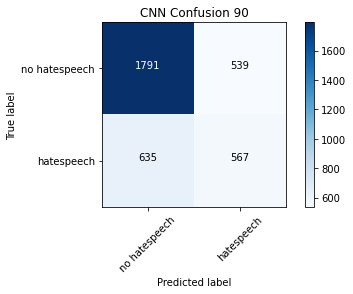

In [29]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='CNN Confusion 90')